In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pandas as pd
import numpy as np
import geopandas as gpd

In [2]:
df = pd.read_csv('C:/Users/Michael/Documents/ml_zc/datosObtenidos/geoespaciales.csv')

# datos de pobreza
nbi = pd.read_excel('C:/Users/Michael/Documents/ml_zc/datosObtenidos/NBI_parroquia.xlsx', sheet_name='data', dtype={'ADM3_PCODE': str})

# datos de empleo
empleo = pd.read_excel('C:/Users/Michael/Documents/ml_zc/datosObtenidos/empleo_parroquial.xlsx', dtype={'ADM3_PCODE': str})

In [3]:
# Filtro para el año 2022
df22 = df[df['Año']==2022]

consolidada = pd.merge(df22, empleo, how='left', on=['ADM3_PCODE'])

# Homologar códigos: quitar caractéres 'EC'
consolidada['ADM3_PCODE'] = consolidada['ADM3_PCODE'].str.replace('EC', '', regex=False)

# Unir pobreza
consolidada = pd.merge(consolidada, nbi, how='left', on=['ADM3_PCODE'])


# estandarizar nombres usados en el artículo
consolidada = consolidada.rename(columns={'avg_rad_max': 'viirs', 'm2': 'm2_auo', 'edificaciones': 'edi', 'carreteras': 'crts', 
                                          'densidad': 'dt', 'numero_componentes': 'ct', 'densidad_servicios': 'ds', 'numero_componentes_servicios':'cs', 
                                          'num_red_agua': 'nra', 'educativos': 'edu', 'avg_ndvi': 'ndvi', 'avg_mndwi': 'mndwi'})

In [4]:
consolidada.shape

(1041, 25)

In [5]:
#consolidada

In [6]:
consolidada.columns

Index(['ADM3_PCODE', 'Año', 'viirs', 'pop', 'm2_auo', 'edi', 'crts', 'dt',
       'ct', 'ds', 'cs', 'edu', 'ndvi', 'mndwi', 'area',
       'Número total de personas de 15 años o más', 'Ocupada', 'Desocupada',
       'Fuera de la fuerza de trabajo', 'Provincia', 'Cantón', 'Parroquia',
       'Personas', 'No pobres', 'Pobres'],
      dtype='object')

In [7]:
# Calculamos el % nbi
consolidada = consolidada.copy()
consolidada['nbi'] = consolidada['Pobres']/consolidada['Personas']

# Calculamos área urbana ocupada
consolidada['auo'] = consolidada['m2_auo']/consolidada['area']

# Ajustemos los VIIR de cm^2 a m^2
consolidada['viirs_m2'] = consolidada['viirs']*1e4

# Calculemos la tasa de empleo
consolidada['er'] = consolidada['Ocupada']/consolidada['Fuera de la fuerza de trabajo']

In [8]:
# Vamos a aplicar una transformación monótona de logartimos adelante, así que 
# necesito restringir mi análisis a datos que existan
poblacion_parroquias = consolidada # antes crearemos una tabla con todas las parroquias
consolidada = consolidada[(consolidada['m2_auo'] > 0) & (consolidada['edi'] > 0) & (consolidada['edu'] > 0) & (consolidada['ds'] > 0)]

# y llenamos los nas con 0s
consolidada = consolidada.fillna(0)

# Descriptivos

In [9]:
# Vamos a construir una variable que sea la densidad de edificios por cada metro cuadrado
consolidada['de'] = consolidada['edi']/consolidada['m2_auo']

# Y otra que sea el consumo percápita de luz expresado en metros
consolidada['rpc'] = consolidada['viirs_m2']/consolidada['pop']

UN ICL normilizando variables

Hay que tener en cuenta de que el número de edificios es pequeño respecto a los metros cuadrados, lo que también ocurre con la radiancia nocturna respecto a la población. En este sentido, podemos construir el ICL usando normalización de variables, como se muestra a continuación.

In [10]:
# Escalemos la variable por método de máximo y mínimos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Vamos a construir una variable que sea la densidad de edificios por cada metro cuadrado
consolidada['ediNorm'] = scaler.fit_transform(consolidada[['edi']])
consolidada['auNorm'] = scaler.fit_transform(consolidada[['m2_auo']])

#
consolidada['rm2Norm'] = scaler.fit_transform(consolidada[['viirs_m2']])
consolidada['popNorm'] = scaler.fit_transform(consolidada[['pop']])
consolidada['ICLvNorm'] = consolidada['rm2Norm']/consolidada['popNorm']*consolidada['auNorm']/consolidada['ediNorm']

In [11]:
variables_a_revisar = ['nbi', 'pop', 'auo', 'crts', 'edi', 'dt', 'ct', 'ds', 'cs', 'edu', 'ndvi', 'mndwi', 'er', 'de', 'rpc'] # 'ICLvNorm'
consolidada[variables_a_revisar].describe()

,nbi,pop,auo,crts,edi,dt,ct,ds,cs,edu,ndvi,mndwi,er,de,rpc
count,123.000000,1.230000e+02,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,1.230000e+02,123.000000
mean,0.436618,8.790159e+04,0.141278,2073.723577,3255.130081,0.001495,40.414634,0.148009,2.707317,26.276423,0.328822,-0.208714,1.309621,1.047926e-03,3.869921
std,0.207904,3.045233e+05,0.238110,6886.034814,8901.088098,0.011237,123.072145,0.247284,3.335678,66.633116,0.206538,0.125812,0.408230,5.684552e-03,5.036294
min,0.094918,4.430000e+02,0.000027,4.000000,1.000000,0.000010,1.000000,0.001900,1.000000,1.000000,0.000000,-0.428526,0.326389,2.945714e-07,0.054815
25%,0.276978,9.130000e+03,0.005705,329.500000,29.000000,0.000160,9.000000,0.020323,1.000000,3.000000,0.169681,-0.297258,0.995787,8.790538e-06,0.691069
50%,0.413288,2.328900e+04,0.026932,643.000000,233.000000,0.000356,14.000000,0.055556,1.000000,7.000000,0.348262,-0.253661,1.244763,8.387936e-05,1.818357
75%,0.598695,5.287450e+04,0.130828,1281.500000,1221.500000,0.000623,32.000000,0.138095,3.000000,16.000000,0.487752,-0.129951,1.600008,2.350444e-04,4.697994
max,0.974007,2.792588e+06,0.994587,68586.000000,51099.000000,0.125000,1257.000000,1.000000,23.000000,519.000000,0.708302,0.084343,2.558431,6.127519e-02,33.225173


Aún así existen cocientes que arrojan números muy pequeños (próximos al cero), por lo que usaremos construirémos un ICL con linealización por logaritmos.

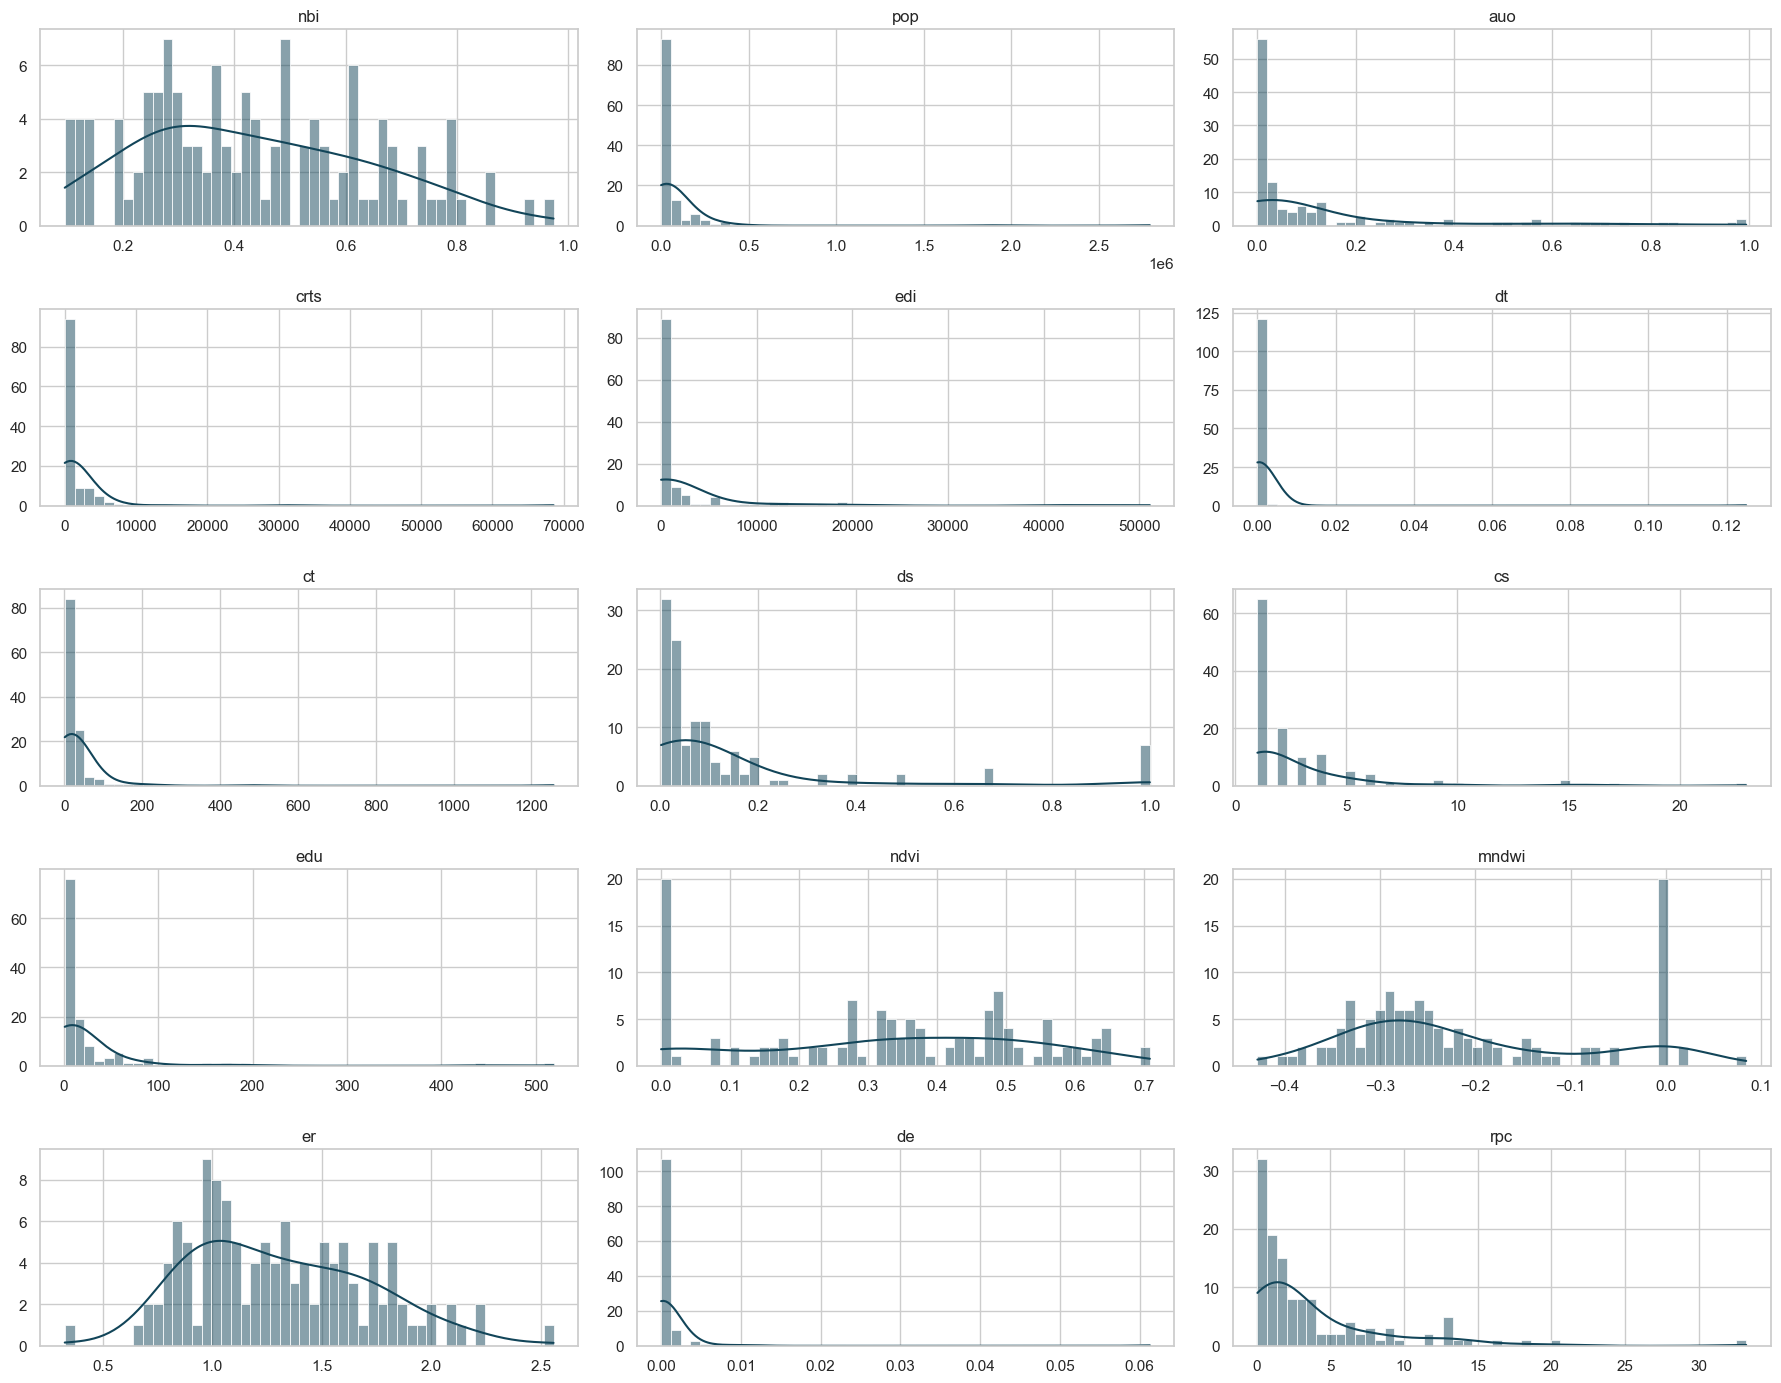

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ajustar estilo
sns.set(style="whitegrid")

# Crear figura
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 14))  # Ajusta según cuántas variables tengas
axes = axes.flatten()

# Iterar sobre las variables y dibujar histogramas bonitos
for i, var in enumerate(variables_a_revisar):
    sns.histplot(data=consolidada, x=var, bins=50, kde=True, color="#124559", ax=axes[i])
    axes[i].set_title(f'{var}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Ocultar ejes vacíos si hay menos variables que subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
fig.savefig("distribuciones_variables.png", dpi=300)
plt.show()

Las distribuciones en algunso casos están muy concentradas, por lo que linealizaremos con logarimos para estudiar mejor las relaciones.

In [13]:
# Histogramas
consolidada = consolidada.copy()
consolidada['log_pop'] = np.log(consolidada['pop'])
consolidada['log_auo'] = np.log(consolidada['auo'])
consolidada['log_crts'] = np.log(consolidada['crts'])
consolidada['log_edi'] = np.log(consolidada['edi'])
consolidada['log_dt'] = np.log(consolidada['dt'])
consolidada['log_ct'] = np.log(consolidada['ct'])
consolidada['log_ds'] = np.log(consolidada['ds'])
consolidada['log_cs'] = np.log(consolidada['cs'])
consolidada['log_edu'] = np.log(consolidada['edu'])
consolidada['log_viirs'] = np.log(consolidada['viirs'])

# Linealizar variables construídas
consolidada['log_de'] = np.log(consolidada['de'])
consolidada['log_rpc'] = np.log(consolidada['rpc'])

consolidada['log_ICLvNorm'] = np.log(consolidada['ICLvNorm'])

C:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Además, construiremos el ICL

In [14]:
consolidada['ICL'] = consolidada['log_rpc']/consolidada['log_de']

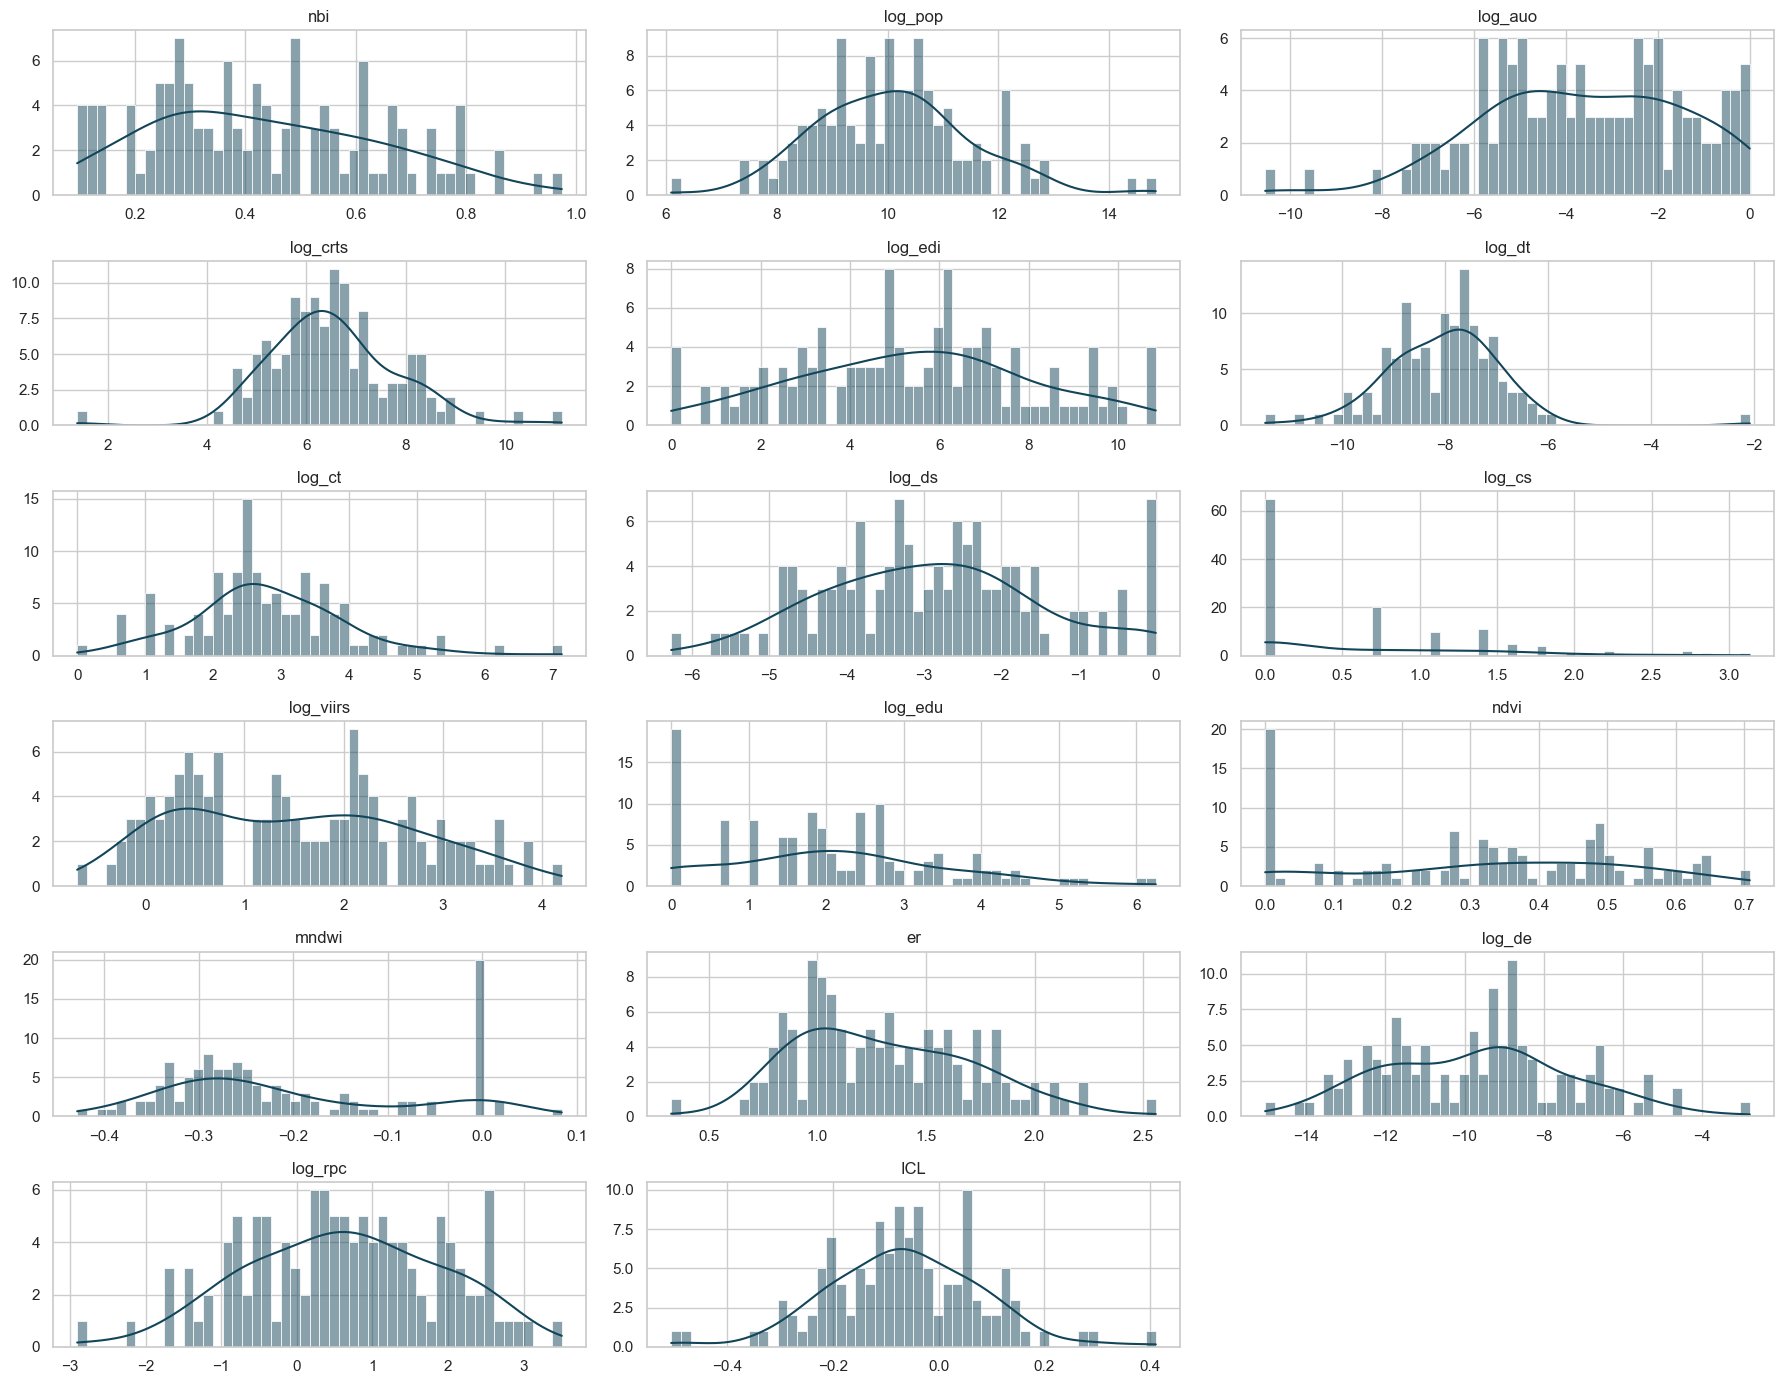

In [15]:
# Graficar

# Ver relaciones
varias = ['nbi', 'log_pop', 'log_auo', 'log_crts', 'log_edi', 'log_dt', 'log_ct', 'log_ds', 'log_cs', 'log_viirs', 'log_edu', 
          'ndvi', 'mndwi', 'er', 'log_de', 'log_rpc', 'ICL'] # 'log_ICLvNorm'
#consolidada[varias].hist(bins=50, figsize=(20, 15))
#plt.show()

# Ajustar estilo
sns.set(style="whitegrid")

# Crear figura
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 14))  # Ajusta según cuántas variables tengas
axes = axes.flatten()

# Iterar sobre las variables y dibujar histogramas bonitos
for i, var in enumerate(varias):
    sns.histplot(data=consolidada, x=var, bins=50, kde=True, color="#124559", ax=axes[i])
    axes[i].set_title(f'{var}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Ocultar ejes vacíos si hay menos variables que subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
fig.savefig("distribuciones_variables_ajustadas.png", dpi=300)
plt.show()

In [16]:
# En adelante, usaremos solo un grupo de variables para la elección de variables
# ya que descontraremos edi por tener de y log_rpc porque contamos con viirs

varias = ['nbi', 'log_pop', 'log_auo', 'log_crts', 'log_dt', 'log_ct', 'log_ds', 'log_cs', 'log_viirs', 'log_edu', 
          'ndvi', 'mndwi', 'er', 'log_de', 'ICL'] # 'log_ICLvNorm'

# 'log_ICLvNorm', ya no es útil 'log_edi', ya que tenemos log_de

# Correlaciones

In [ ]:
# Gráfico mejorado

# pairplot con línea de tendencia (regresión lineal)
sns.pairplot(consolidada[varias], kind='reg', plot_kws={'line_kws':{'color':'red'}})

plt.gcf().set_size_inches(25, 20)
plt.savefig("grafCorre.png", dpi=300)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlación
corr = consolidada[varias].corr(numeric_only=True)

# Establecer tamaño de figura más grande
plt.figure(figsize=(16, 12))  # Cambia el tamaño aquí

# Crear heatmap con más estilo
sns.heatmap(
    corr,
    annot=True,              # Muestra los valores
    fmt=".2f",               # Formato de los números
    cmap="coolwarm",         # Paleta de colores
    annot_kws={"size": 12},  # Tamaño del texto dentro de los cuadros
    cbar_kws={"shrink": 0.8} # Barra de color más pequeña
)

# Títulos y etiquetas más grandes
plt.title("Matriz de Correlación", fontsize=20, fontweight="bold", pad=20)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

# Modelo

## Selección de variables

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Método hacia adelante
def forward_selection_sklearn(X, y, modelo=None, max_features=None, verbose=True):
    """
    Selección hacia adelante con sklearn usando MSE como criterio.

    Parámetros:
        X            : DataFrame con variables predictoras
        y            : Serie o array de variable objetivo
        modelo       : Modelo sklearn (por defecto LinearRegression)
        max_features : Número máximo de variables a seleccionar
        verbose      : Mostrar progreso o no

    Retorna:
        Lista de nombres de variables seleccionadas
    """
    if modelo is None:
        modelo = LinearRegression()

    remaining_features = list(X.columns)
    selected_features = []
    current_score = np.inf
    n_features = max_features if max_features else X.shape[1]

    for _ in range(n_features):
        scores = []
        for candidate in remaining_features:
            features_to_test = selected_features + [candidate]
            modelo.fit(X[features_to_test], y)
            y_pred = modelo.predict(X[features_to_test])
            mse = mean_squared_error(y, y_pred)
            scores.append((mse, candidate))

        scores.sort()
        best_new_score, best_candidate = scores[0]

        if best_new_score < current_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            current_score = best_new_score
            if verbose:
                print(f"Agregado: {best_candidate}, MSE: {current_score:.4f}")
        else:
            break

    return selected_features


# Hacia atrás
def backward_elimination_sklearn(X, y, modelo=None, min_features=1, verbose=True):
    """
    Eliminación hacia atrás con sklearn usando MSE como criterio.

    Parámetros:
        X            : DataFrame con variables predictoras
        y            : Serie o array con variable objetivo
        modelo       : Modelo sklearn (por defecto LinearRegression)
        min_features : Número mínimo de variables a conservar
        verbose      : Mostrar progreso

    Retorna:
        Lista de variables seleccionadas
    """
    if modelo is None:
        modelo = LinearRegression()

    selected_features = list(X.columns)
    current_score = np.inf

    while len(selected_features) > min_features:
        scores = []
        for candidate in selected_features:
            features_to_test = [f for f in selected_features if f != candidate]
            modelo.fit(X[features_to_test], y)
            y_pred = modelo.predict(X[features_to_test])
            mse = mean_squared_error(y, y_pred)
            scores.append((mse, candidate))

        # Encontrar variable cuya eliminación mejora más (o empeora menos)
        scores.sort()
        best_new_score, worst_candidate = scores[0]

        if best_new_score < current_score:
            selected_features.remove(worst_candidate)
            current_score = best_new_score
            if verbose:
                print(f"Eliminado: {worst_candidate}, MSE: {current_score:.4f}")
        else:
            break

    return selected_features

Datos de partida

In [ ]:
df = consolidada[varias]
print(df.shape)

# Suponiendo que tienes un DataFrame df
X = df.drop("nbi", axis=1)
y = df["nbi"]

Rendimiento seleccionando hacia adelante

In [ ]:
from sklearn.linear_model import LinearRegression
modelo = LinearRegression()

# Por método hacia adelante 
m1 = forward_selection_sklearn(X, y, modelo=modelo)
print("Variables seleccionadas:", m1)

# Por método hacia atrás
m2 = backward_elimination_sklearn(X, y, modelo)
print("Variables seleccionadas:", m2)

In [ ]:
# Método por regularización: Lasso y ElasticNet
from sklearn.linear_model import LassoCV

modelo = LassoCV(cv=5).fit(X, y)
coef = pd.Series(modelo.coef_, index=X.columns)
m3 = coef[coef != 0].index.tolist()
m3

In [ ]:
# la 
from sklearn.linear_model import ElasticNetCV

# Ajustar ElasticNet con validación cruzada
modelo_en = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(X, y)

# Extraer coeficientes distintos de cero
coef_en = pd.Series(modelo_en.coef_, index=X.columns)
m3_1 = coef_en[coef_en != 0].index.tolist()
m3_1

In [ ]:
# 2. Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe = RFE(LinearRegression(), n_features_to_select=5)
rfe.fit(X, y)
m4 = X.columns[rfe.support_]
m4

In [ ]:
# Modelos basados en importancia (Tree-based)
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X, y)
importancia = pd.Series(rf.feature_importances_, index=X.columns)
importancia.sort_values(ascending=False).plot(kind='bar')

In [ ]:
m5 = importancia.to_frame().reset_index()['index'].tolist()
m5

In [ ]:
# Filtros estadísticos
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd

# X: DataFrame con variables predictoras
# y: Serie con variable objetivo

# Crear selector que elige las k mejores variables (por ejemplo, 5)
selector = SelectKBest(score_func=f_regression, k=7)

# Ajustar selector a los datos
selector.fit(X, y)

# Obtener booleanos de variables seleccionadas
mask = selector.get_support()

# Filtrar columnas seleccionadas (nombres)
m6 = X.columns[mask]

print("Variables seleccionadas:", list(m6))

In [ ]:
# Por método Boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# Supón que X es un array o dataframe y y la variable objetivo
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)

boruta_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=2,
    random_state=42
)

boruta_selector.fit(X.values, y.values)

# Variables seleccionadas
m7 = X.columns[boruta_selector.support_].to_list()
print("Variables seleccionadas por Boruta:", m7)

# Análisis econométrico

In [ ]:
import statsmodels.api as sm 
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [ ]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# agrego constanets
X1 = sm.add_constant(X[m1])
X2 = sm.add_constant(X[m2])
X3 = sm.add_constant(X[m2])
X4 = sm.add_constant(X[m4])
X5 = sm.add_constant(X[m5])
X6 = sm.add_constant(X[m6])
X7 = sm.add_constant(X[m7])

# especifico modelos
model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()
model4 = sm.OLS(y, X4).fit()
model5 = sm.OLS(y, X5).fit()
model6 = sm.OLS(y, X6).fit()
model7 = sm.OLS(y, X7).fit()

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera

# calcular VIF
def calcular_max_vif(X):
    if 'const' in X.columns:
        X_vif = X.drop(columns='const')
    else:
        X_vif = X.copy()
    vif_vals = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    return max(vif_vals)

# resumir métricas modelos
def resumen_modelo(model, X, y):
    bp_test = het_breuschpagan(model.resid, X)
    max_vif = calcular_max_vif(X)
    jb_pval = jarque_bera(model.resid)[2]


    return {
        'DW': round(durbin_watson(model.resid), 2),
        'Breusch-Pagan p-val': round(bp_test[1], 3),
        'JB p-val': round(jb_pval, 3),
        'Max VIF': round(max_vif, 2),
        'F-stat': round(model.fvalue, 2),
        'F p-val': round(model.f_pvalue, 3)
    }

In [ ]:
# Lista de modelos y sus X correspondientes
modelos = [model1, model2, model3, model4, model5, model6, model7]
Xs = [X1, X2, X3, X4, X5, X6, X7]
nombres = [f'Modelo {i}' for i in range(1, 8)]

# Crear tabla resumen
resumenes = [resumen_modelo(m, X, y) for m, X in zip(modelos, Xs)]
df_resumen = pd.DataFrame(resumenes, index=nombres)

print(df_resumen)

Correción del modelo 3

In [ ]:
model4 = sm.add_constant(X[m4])

# especifico modelos
model_def = sm.OLS(y, model4).fit(cov_type='HC1')
resumen_modelo(model_def, model4, y)

In [ ]:
model_def.summary()

Resultado

In [ ]:
print(model_def.summary().as_latex())

Verificar autocorrelación espacial

In [ ]:
df

## Efectos de la urbanidad

¿Existe autocorrelación espacial?

In [ ]:
# Cargar shapefile local
shapefile_path = "C:/Users/Michael/Documents/ml_zc/ecu_adm_2024/ecu_adm_adm3_2024.shp"
gdf = gpd.read_file(shapefile_path)

gdf = gdf[['ADM3_PCODE', 'geometry']]
gdf['ADM3_PCODE'] = gdf['ADM3_PCODE'].str.replace('EC', '', regex=False)
geodf = consolidada[['ADM3_PCODE']].merge(gdf, how='left', on='ADM3_PCODE')

In [ ]:
# añado constantes
addConstantes = sm.add_constant(X[m4])

# especifico modelos
modeloB_para_ajuste = sm.OLS(y, addConstantes).fit(cov_type='HC1')


modeloB_para_ajuste.summary()


# Residuos
residuals = modeloB_para_ajuste.resid

from esda.moran import Moran
from libpysal.weights import Queen

w = Queen.from_dataframe(geodf)  # geodf: GeoDataFrame con las parroquias
moran_resid = Moran(residuals, w)

print("Moran's I:", moran_resid.I)
print("p-value:", moran_resid.p_sim)

Ajustaremos los pesos por vecinos cercanos, a continuación vemos cuántos hay que usar

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from libpysal.weights import KNN
from spreg import GM_Error

# Definimos el rango de k
k_values = range(2, 16)
r2_values = []

# Variables independientes según tu última imagen
X_vars = df[['log_ct', 'log_viirs', 'ndvi', 'mndwi', 'er']]

for k in k_values:
    # Generar matriz de pesos
    w_k = KNN.from_dataframe(geodf, k=k)
    w_k.transform = 'r'
    
    # Ajustar modelo
    model = GM_Error(y, X_vars, w=w_k)
    
    # Usamos pr2 (Pseudo R-squared) como métrica de comparación
    r2_values.append(model.pr2)

# --- Generación del Gráfico ---
plt.figure(figsize=(10, 5))
plt.plot(k_values, r2_values, marker='s', color='#e67e22', linewidth=2)
#plt.title('Selección de K basada en Pseudo $R^2$', fontsize=14)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Pseudo R-squared', fontsize=12)
plt.grid(True, alpha=0.3)

# Identificar el mejor k
best_k = k_values[np.argmax(r2_values)]
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k: {best_k}')
plt.legend()

plt.savefig("numberofk.png", dpi=300)
plt.show()

print(f"El valor de k que maximiza el ajuste (R2) es: {best_k}")

In [ ]:
#Vamos a ajustar por una matriz de pesos por distancia (contiguidad)
from libpysal.weights import KNN
from spreg import GM_Error

w = KNN.from_dataframe(geodf, k=3)
w.transform = 'r'

sem_model = GM_Error(y, df[m4], w=w)
print(sem_model.summary)

In [ ]:
# añado constantes
#addConstantes = sm.add_constant(X[['log_auo', 'log_viirs']])

# especifico modelos
#modeloB_para_ajuste = sm.OLS(y, addConstantes).fit(cov_type='HC1')


#modeloB_para_ajuste.summary()

# Clustering

In [ ]:
import gower

In [ ]:
df2 = df.dropna() #.drop(columns=['nbi'])

In [ ]:
# Creamos una matriz cruzada con las distancias
distance_matrix = gower.gower_matrix(df2)
pd.DataFrame(distance_matrix) 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Instancia de escalador estándar
scaler = StandardScaler()

# Ajustar y transformar datos
df_scaled = scaler.fit_transform(distance_matrix)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


def cluster(model, X_scaled, method):
    # Seed
    np.random.seed(35735)

    # Estimación
    model.fit(X_scaled)

    # Numero de clusters
    clusters = model.labels_
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # No contar ruido (-1)

    # Resultados
    print(f'\nModel Report\n{method}\n')
    print(f'Number of clusters: {num_clusters}\n')

    if num_clusters >= 2:
        silh_score = silhouette_score(X_scaled, clusters)
        print(f'Silhouette Coefficient: {silh_score:.3f}')
    else:
        print('Silhouette Coefficient: No se puede calcular (solo 1 cluster o solo ruido).')
    
    return clusters

In [ ]:
# Simulamos un dataset de ejemplo si no tienes tus datos cargados
from sklearn.datasets import make_moons

X, _ = make_moons(n_samples=300, noise=0.1, random_state=42)

# Escalamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Graficar k-distance para eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])  # 4 porque min_samples=5 normalmente

plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('K-distance plot')
plt.xlabel('Points')
plt.ylabel('5th Nearest Neighbor Distance')
plt.show()


In [ ]:
# Definir DBSCAN
dbscan_model = DBSCAN(eps=0.3, min_samples=5)  # Ajusta eps según tu caso

# Aplicar tu función
labels = cluster(dbscan_model, X_scaled, method='DBSCAN')

In [ ]:
# Graficar los clusters
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Relaciones

In [ ]:
df.columns

In [ ]:
df.columns

In [ ]:
# Preparar agrupadores
df['viirs interval'] = pd.qcut(df['log_viirs'], q=5, labels=[
    'Very low', 'Low', 'Medium', 'High', 'Very high'
])

df['ICL interval'] = pd.qcut(df['ICL'], q=5, labels=[
    'Very low', 'Low', 'Medium', 'High', 'Very high'
])

df['auo interval'] = pd.qcut(df['log_auo'], q=5, labels=[
    'Very low', 'Low', 'Medium', 'High', 'Very high'
])

df['de interval'] = pd.qcut(df['log_de'], q=5, labels=[
    'Very low', 'Low', 'Medium', 'High', 'Very high'
])

df['ctrs interval'] = pd.qcut(df['log_crts'], q=5, labels=[
    'Very low', 'Low', 'Medium', 'High', 'Very high'
])

df['ct interval'] = pd.qcut(df['log_ct'], q=5, labels=[
    'Very low', 'Low', 'Medium', 'High', 'Very high'
])

df['nbi interval'] = pd.qcut(df['nbi'], q=5, labels=[
    'Very low', 'Low', 'Medium', 'High', 'Very high'
])

In [ ]:
df.columns

In [ ]:
# Crear el scatter plot
plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    data=df,
    x='er',
    y='nbi',
    size='log_viirs',
    hue='auo interval',  # Colorea por provincia intervalo_ctrs
    sizes=(20, 300),
    alpha=0.6,
    palette='tab10',  # Puedes cambiar esto por otro colormap como 'Set2', 'Dark2', etc.
    legend=True
)

# Línea de regresión global
sns.regplot(
    data=df,
    x='er',
    y='nbi',
    scatter=False,
    color='red',
    line_kws={"linewidth": 2}
)

# Estética
plt.xlabel('Employment rate')
plt.ylabel('NBI')
#plt.title('')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("efectos.png", dpi=300)
plt.show()

## ICL para resumir urbanidad

In [ ]:
# Gráfico base que iremos mejorando en el siguiente bloque
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
y = np.random.rand(50)

# Crear figura 2 filas x 3 columnas
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

# Poner los gráficos en las primeras cuatro celdas
axs[0, 0].scatter(df['log_auo'], df['ICL'], color='blue', alpha=0.6)
axs[0, 0].set_title('Gráfico 1')
# Línea de regresión global
sns.regplot(
    data=df,
    x='er',
    y='nbi',
    scatter=False,
    color='red',
    line_kws={"linewidth": 2}
)

# Estética
plt.xlabel('Employment rate')
plt.ylabel('NBI')
#plt.title('')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


axs[0, 1].scatter(df['log_crts'], df['ICL'], color='green', alpha=0.6)
axs[0, 1].set_title('Gráfico 2')

axs[0,2].scatter(df['log_dt'], df['ICL'], color='red')
axs[0,2].set_title('Gráfico 3')

axs[1, 0].scatter(df['log_ct'], df['ICL'], color='purple')
axs[1, 0].set_title('Gráfico 4')

axs[1, 1].scatter(df['log_edu'], df['ICL'], color='purple')
axs[1, 1].set_title('Gráfico 5')

axs[1, 2].scatter(df['log_viirs'], df['ICL'], color='purple')
axs[1, 2].set_title('Gráfico 6')

# Las otras dos celdas las dejamos vacías
#axs[1, 1].axis('off')
#axs[1, 2].axis('off')

# Ajustar espacios
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Crear figura 2 filas x 3 columnas
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

# Lista de variables X
x_vars = ['log_auo', 'log_crts', 'log_dt', 'log_ct', 'log_edu', 'log_viirs']

# Color elegante para los puntos
point_color = '#1f77b4'  # azul elegante

# Recorrer cada gráfico
for i, x_col in enumerate(x_vars):
    row = i // 3
    col = i % 3

    # Scatter plot
    axs[row, col].scatter(df[x_col], df['ICL'], color=point_color, alpha=0.7, s=40)

    # Línea de regresión
    m, b = np.polyfit(df[x_col], df['ICL'], 1)
    x_fit = np.linspace(df[x_col].min(), df[x_col].max(), 100)
    y_fit = m * x_fit + b
    axs[row, col].plot(x_fit, y_fit, color='black', linestyle='--', linewidth=1.5)

    # Poner el nombre de la variable X como etiqueta de eje X en todos los gráficos
    axs[row, col].set_xlabel(x_col, fontsize=11)

# Etiqueta Y común centrada a la izquierda
fig.text(0.02, 0.5, 'ICL', va='center', ha='center', rotation='vertical', fontsize=12)

# Ajustar espacios
plt.tight_layout()

# Guardar la figura
plt.savefig('ICL.png', dpi=300, bbox_inches='tight')
plt.show()


Diferenciar población de la lista de parroquias usada en el estudio

In [ ]:
# Obtener una linsta de las parroquias usadas para el estudio
a_orded = consolidada.sort_values(by='nbi', ascending=False)[['ADM3_PCODE', 'nbi']]
b_orded = df.sort_values(by='nbi', ascending=False)

# unir por columnas ordenadas
df_cbind = pd.concat([a_orded, b_orded], axis=1)

# conservo las columnas de nbi para verificar que sean las mismas parroquias
df_cbind.to_excel('muestra_parroquias.xlsx', index=False)

# Agregar marca de que está en la muestra:
df_cbind['muestra'] = 1

# Finalmente, exporto un archivo con la lista de parroquias empleadas en el estudio marcadas en la columna "muestra" 
popmarcada = poblacion_parroquias.merge(df_cbind[['ADM3_PCODE', 'muestra']], on='ADM3_PCODE', how='left')
popmarcada.to_excel('poblacion_paroquias.xlsx', index=False)